# Phys 581 Winter 2019
# Report #1: Cluster computing
## Alexander Hickey, 10169582

Note that the contents of this notebook were created and tested on an Ubuntu 18.04.2 machine, using Python 2.7.16. This machine is connected to the physics junior lab network, which is the network used to construct the computing cluster. The parallel python library used in this notebook is not supported in Python 3+.

In [1]:
import sys
sys.version

'2.7.16 |Anaconda, Inc.| (default, Mar 14 2019, 21:00:58) \n[GCC 7.3.0]'

### Introduction

As explored in Assignment 5, the Multiprocessing module offers a convenient means of parallelizing the execution of a function across multiple input values. This allows one to side-step the notorious Python global interpreter lock, by spawning subprocesses rather than threads. The simplest, and arguably most useful function of the multiprocessing package is the Pool object, which spawns multiple independent computations in parallel. This is ideal in cases where one is performing repetetive computations that are independent of one another, for example, performing a function on some large list of values, where the results are independent of one another. 

One of the downsides of any simple implementation of the multiprocessing module, is that the efficiency of performing tasks in parallel is limited by the number of physical cores present on the device. Often times however, one has access to many computers that are a part of the same network. It is therefore of interest to be able to run tasks in parallel across an entire network of CPUs, rather than just on a single device. This technique of getting multiple computers across a network to work together is known as cluster computing.

This report will explore the construction and efficiency of a computing cluster, using the Parallel Python package. In particular, I will use this framework to construct a cluster with the maximum number of CPUs available over the network in the physics junior labs.

### Construction of the cluster

The first step to constructing the computing cluster is to generate a list of all of the valid IP addresses in the junior labs. This can be obtained readily by attempting to establish an ssh connection using the paramiko library in Python. Both the parallel python and paramiko libraries can be installed in anaconda using:
    
    conda install -c geneko pp
    conda install -c anaconda paramiko

Additionally, the ability to ssh using the paramiko library will allow us to set up the parallel python server on each machine in the network, which effectively adds the machine as a node to the computing cluster.

In [2]:
#Import useful libraries
import pp, paramiko
import commands
import matplotlib.pyplot as plt
import time
import getpass
%matplotlib inline

In order to establish an ssh connection, my Ucalgary username and password will be required for authentication. There is a handy library built in to Python called "getpass" that prompts the user for their password and saves it to a variable without displaying it on screen. Additionally, the getpass library allows one to retrieve their current username.

In [3]:
#Retrieve username and prompt user for password
user = getpass.getuser()
passw = getpass.getpass('Password for '+user+': ')

Password for alexander.hickey: ········


All of the computers in the junior labs have an IP address of the form 136.159.54.X where X is an integer between 0 and 255. Using the paramiko, we can attempt to interface with each device in the lab by trying to open an ssh connection. If this connection is successful, I store that IP to a list of valid hosts that can later be used in our cluster. If the connection fails, I ignore this IP. This will give us an idea of the number of machines available over the network.

In [5]:
#Set network base IP
IP_base = '136.159.54.'

#Retrieve current IP
myIP = commands.getoutput("hostname -I")[:-1]

#List of valid host IPs
hostlist = []

#Search through junior lab IPs and attempt to connect
for j in range(1,255):
    
    #Current IP
    hostname = IP_base+str(j)
    
    #Try to connect, with statement used so thatclient is not stored.
    try:
        with paramiko.SSHClient() as ssh:
            
            #Set host key policy
            ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
            
            #Connect using current IP, timout after 0.1s
            ssh.connect(hostname, username=user, password=passw,timeout=.1)
            
            #Close connection and add to list of valid IPs
            hostlist.append(hostname)
    
    #Move on to next IP if exception error is rased
    except:
        None

if myIP in hostlist:
    hostlist.remove(myIP)
print 'Successfully connected to %s hosts:' %len(hostlist) 
print(hostlist)

Successfully connected to 59 hosts:
['136.159.54.20', '136.159.54.21', '136.159.54.22', '136.159.54.25', '136.159.54.26', '136.159.54.27', '136.159.54.28', '136.159.54.29', '136.159.54.30', '136.159.54.31', '136.159.54.33', '136.159.54.34', '136.159.54.35', '136.159.54.36', '136.159.54.37', '136.159.54.38', '136.159.54.39', '136.159.54.41', '136.159.54.43', '136.159.54.44', '136.159.54.45', '136.159.54.46', '136.159.54.47', '136.159.54.48', '136.159.54.49', '136.159.54.50', '136.159.54.51', '136.159.54.52', '136.159.54.54', '136.159.54.55', '136.159.54.56', '136.159.54.57', '136.159.54.58', '136.159.54.59', '136.159.54.60', '136.159.54.61', '136.159.54.62', '136.159.54.63', '136.159.54.64', '136.159.54.67', '136.159.54.68', '136.159.54.70', '136.159.54.71', '136.159.54.72', '136.159.54.73', '136.159.54.74', '136.159.54.75', '136.159.54.76', '136.159.54.79', '136.159.54.80', '136.159.54.81', '136.159.54.82', '136.159.54.83', '136.159.54.84', '136.159.54.85', '136.159.54.86', '136.159.54

As we see, we were able to successfully ssh into 59 devices over the network. With an average of 4 cores per computer in the lab, this should give us a noticable boost in computational power. Next, we set up the parallel python server on each one of the available machines. By running the ppserver.py file included in the parallel python distribution, a machine will become available to interface with the parallel python server and become a node in the computing cluster. Upon running this notebook with the full 59 nodes, it seems that python forces parallel python to crash because it is starting too many threads. We will therefore only consider a smaller cluster consisting of 20 nodes.

In [6]:
# Terminal command to activate the parallel python server.
# Python27 corresponds to a conda environment on my account
# that is used to run Python 2.7.16. The -a command enables
# the auto-discovery service of the server.
command = 'conda activate Python27 && ppserver.py -a'

#Shorten list of hosts to prevent crash from thread
hostlist = hostlist[:20]

#Counter
cnt = 0

#Start client on each valid host
for host in hostlist:
    try:
        with paramiko.SSHClient() as ssh:
            
            #Set host key policy
            ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
            
            #Connect to host
            ssh.connect(host, username=user, password=passw,timeout=2)
            
            #Execute command on host
            ssh.exec_command(command)
            
            #Update counter
            cnt += 1

    except:
        None
        
print 'ppserver.py executed on %s hosts'%cnt

ppserver.py executed on 20 hosts


Now that the servers are running, we are ready to create a job server to add each of these machines as a node in our computing cluster.

In [7]:
#Activate job server using available machines
job_server = pp.Server(ppservers = tuple(hostlist))

From this server, we can fetch a dictionary that shows each active node, as well as the number of CPUs of each node.

In [8]:
#Show active nodes in the cluster
nodes = job_server.get_active_nodes()
nodes

{'136.159.54.20:60000': 4,
 '136.159.54.21:60000': 4,
 '136.159.54.22:60000': 4,
 '136.159.54.25:60000': 4,
 '136.159.54.26:60000': 4,
 '136.159.54.27:60000': 4,
 '136.159.54.28:60000': 4,
 '136.159.54.29:60000': 4,
 '136.159.54.30:60000': 4,
 '136.159.54.31:60000': 4,
 '136.159.54.33:60000': 4,
 '136.159.54.34:60000': 4,
 '136.159.54.35:60000': 4,
 '136.159.54.36:60000': 4,
 '136.159.54.37:60000': 4,
 '136.159.54.38:60000': 4,
 '136.159.54.39:60000': 4,
 '136.159.54.41:60000': 4,
 '136.159.54.43:60000': 4,
 '136.159.54.44:60000': 4,
 'local': 4}

In [9]:
#Total number of CPUs available
ncpus = sum(nodes.values())
print('There are %s CPUs available in the cluster'%ncpus)

There are 84 CPUs available in the cluster


With the clusters ready to use, we can now send tasks to the job server to execute. To test the number of tasks that are running in parallel, I will use the time.sleep function to set a 1 second delay at each function call. By sending many delays to the job server, we are able to test if the processes are truly running in parallel.

In [10]:
def sleep(x):
    '''
    This function will cause a 1second delay
    and return the number 1
    '''
    
    #Delay by 1 second
    time.sleep(1)
    
    return 1

#Iterate over number of total tasks and record wall time
num_tasks = [j for j in range(1,240,5)]
time_list = []

for N in num_tasks:
    
    #Initialize time
    t0 = time.time()
    
    #Submit N jobs to server
    jobs = [job_server.submit(sleep, (1,), modules = ('time',)) for i in range(N)]
    
    #Wait for all jobs on server to finish before continuing
    job_server.wait()
    
    #Record time difference
    time_list.append(time.time()-t0)
    

We can then plot the wall time versus the number of jobs sent to the server.

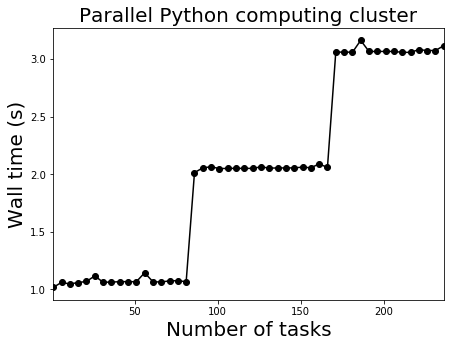

In [11]:
plt.figure(figsize = (7,5))
plt.plot(num_tasks,time_list, color = 'black', marker = 'o')
plt.xlim(min(num_tasks),max(num_tasks))
plt.xlabel('Number of tasks',fontsize = 20)
plt.ylabel('Wall time (s)', fontsize = 20)
plt.title('Parallel Python computing cluster', fontsize = 20)
plt.show()

If the tasks were not run in parallel, we would expect the number of tasks to be equal to the time in seconds, as each task is set to take one second to run. We see that the wall time takes about 1 second for a few number of tasks, and raises slightly above 1 second afterwards. The wall time remains constant up until about 80 tasks, where the wall time almost doubles to approximately two seconds. This suggests that for about 1-80 tasks, the tasks are in fact running in complete parallel, with some delay that most likely arises from constructing the job list, as well as the server communication. After about 80 tasks, there is now some queue of jobs in the server, as there are no longer enough nodes to run all of the tasks simultaneously. This almost exactly corresponds with what we expect, as there are 84 CPUs available in our cluster. At about 160 tasks, we see another jump in the wall time which corresponds to a max of 3 sequential tasks being run on any processor.

Finally, it is probably a good idea to kill the ppserver.py process on each of the machines in the computer lab, otherwise it will essentially be running indefinitely.

In [12]:
#Command to kill all processes on the worker nodes
command = 'pkill -u %s'%user

#Counter
cnt = 0

#Connect to each host
for host in hostlist:
    try:
        with paramiko.SSHClient() as ssh:

            #Set host key policy
            ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
            
            #Connect to host
            ssh.connect(host, username=user, password=passw,timeout=2)
            
            #Run command
            ssh.exec_command(command)
            
            #Close connection
            ssh.close()
            
            #Update counter
            cnt += 1
        
    except:
        None
        
print 'disconnected from %s hosts'%cnt

disconnected from 20 hosts


### Conclusion

In this report, we examined the construction of a computing cluster using the parallel python and paramiko modules in Python. Using the paramiko module, we were able to search through the network and construct a list of reliable connections for our cluster. Furthermore, the paramiko module allowed us to execute the parallel python server on each one of the available worker nodes. We saw that the parallel python library allows one to reliable construct a job server and distribute tasks to the available CPUs in the cluster. Using the time.sleep function, we showed that the tasks are in fact running in parallel, and we can run almost as many simultaneous tasks as the number of CPUs in our cluster.

With more time available, it would be interesting to see how the parallel python library holds up for jobs that are very computationally intensive, so as to max out the usage of each of the available CPUs. This is an important step as computationally intensive tasks are usually the reason that one want to parallelize in the first place. Additionally, it would be interesting to try and bypass the threading limit in python to attempt to construct a larger cluster without parallel python crashing.